# iJN678 Mixotrophic Operation

Set the environment

In [1]:
import cobra.test
import pandas as pd
import numpy as np
import escher
from escher import Builder
import matplotlib.pyplot as plt
from cobrapy_bigg_client import client
from cobra.flux_analysis.loopless import loopless_solution
from cobra.flux_analysis import production_envelope

pd.set_option('display.max_rows', 1000)
pd.set_option('display.width',1000)
pd.set_option('display.max_colwidth',None)

Load and save the model

In [2]:
model_orig = client.download_model('iJN678', save=False) # Loading the model to the simulation
model_orig.solver = 'glpk'
model = model_orig.copy()

Set parameter Username
Academic license - for non-commercial use only - expires 2022-10-10


Model Attribute Summary

In [3]:
model

<Model iJN678 at 0x27c8646d9d0>

## iJN678 Biomass Functions

Find the heterotropic biomass function

In [4]:
for reaction in model.reactions.query('BIOMASS', 'id'):
    print(reaction.id,'   ',reaction.name)

BIOMASS_Ec_SynAuto     Autotrophic Biomass Ecuation
BIOMASS_Ec_SynMixo     Mixotrophic Biomass Ecuation
BIOMASS_Ec_SynHetero     Heterotrophic Biomass Ecuation


Active biomass function

In [5]:
model.reactions.BIOMASS_Ec_SynMixo

<Reaction BIOMASS_Ec_SynMixo at 0x27cac717eb0>

## iJN678 Energy and Reducing Power Subsystems

List the subsystem to determine the name of the oxidative phosphorylation subsystem.

In [6]:
reaction_subsystem = [r.subsystem for r in model.reactions]
subsystem = pd.DataFrame(reaction_subsystem, columns = ['iJN678 Subsystems'])
subsystem = subsystem.drop_duplicates()
subsystem = subsystem.reset_index(drop=True)
subsystem

iJN678 Subsystems
0                               Extracellular exchange
1   Phenylalanine tyrosine and tryptophan biosynthesis
2                              Fatty acid biosynthesis
3                      Arginine and proline metabolism
4                                  Nitrogen metabolism
5                                               Others
6                            Citrate cycle (TCA cycle)
7                                Riboflavin metabolism
8                                    Purine metabolism
9                 Porphyrin and chlorophyll metabolism
10                     Terpenoid backbone biosynthesis
11                                      Photosynthesis
12                               Pyrimidine metabolism
13         Alanine, aspartate and glutamate metabolism
14              Nicotinate and nicotinamide metabolism
15                             Glycerolipid metabolism
16                                Histidine metabolism
17                             Carotenoid Biosynthesis
18                          Glycolysis/Gluconeogenesis
19                                    PHB byosynthesis
20                              Cyanophycin metabolism
21                                 Pyruvate metabolism
22           Urea cycle and metabolism of amino groups
23                                   Biotin metabolism
24                 C5-Branched dibasic acid metabolism
25           Sulfur Cysteine and methionine metabolism
26                            Galactolipids metabolism
27                                 Sterol biosynthesis
28                                 Thiamine metabolism
29                                 Folate biosynthesis
30             Glyoxylate and dicarboxylate metabolism
31                   Pantothenate and CoA biosynthesis
32                              Glutathione metabolism
33                       Starch and sucrose metabolism
34                           Pentose phosphate pathway
35       Ubiquinone and other pterpenoids biosynthesis
36                     Fructose and mannose metabolism
37                                   Lysine metabolism
38                           Oxidative phosphorylation
39                                Glutamate metabolism
40                              Aminosugars metabolism
41                        Nucleotide sugars metabolism
42                                 Hydrogen production
43          Valine leucine and isoleucine biosynthesis
44                                     Carbon fixation
45                       Inositol phosphate metabolism
46                     Lipopolysaccharide biosynthesis
47                          Peptidoglycan biosynthesis
48                               Vitamin B6 metabolism
49                             Sulfolipid Biosynthesis
50                                           Transport
51                           Intracellular source/sink
52                   Biomass and maintenance functions
53                                Intracellular demand
54                                Steroid biosynthesis

For the case of mixotrophic operation, the cell's energy and reducing power will be created by both the "Photosynthesis" and the "Oxidative phosphorylation" subsytems.

To start with let's create a table of the reactions in the "Photosynthesis" subsystem.

In [7]:
reaction_names = [r.name for r in model.reactions]
reaction_ids = [r.id for r in model.reactions]
reaction_formula = [r.reaction for r in model.reactions]
reaction_subsystem = [r.subsystem for r in model.reactions]
reactionList = {'Reaction ID': reaction_ids,
                'Reaction Name': reaction_names,
                'Reaction Formula': reaction_formula,
                'Reaction Subsystem': reaction_subsystem,
               }

df = pd.DataFrame(reactionList, columns= ['Reaction ID','Reaction Name','Reaction Formula','Reaction Subsystem'])
# Select the reactions associated with the desired subsystem
SSindex = []
for i in range(len(reaction_subsystem)):
    if reaction_subsystem[i] == 'Photosynthesis':
        SSindex.append(i)
df_P_ss = df.loc[SSindex]
df_P_ss = df_P_ss.sort_values(by='Reaction ID')
df_P_ss = df_P_ss.reset_index(drop=True)
df_P_ss

Reaction ID                                               Reaction Name                                                               Reaction Formula Reaction Subsystem
0        CBFC2                                     Cytochrome b6/f complex            2.0 ficytc6_u + 2.0 h_c + pqh2_u --> 2.0 focytc6_u + 4.0 h_u + pq_u     Photosynthesis
1        CBFCu                                     Cytochrome b6/f complex                  2.0 h_c + 2.0 pcox_u + pqh2_u --> 4.0 h_u + 2.0 pcrd_u + pq_u     Photosynthesis
2   CYO1b2_syn             Cytochrome c oxidase, synechocystis (2 protons)               4.0 h_c + 0.5 o2_u + 2.0 pcrd_u --> h2o_u + 2.0 h_u + 2.0 pcox_u     Photosynthesis
3    CYO1b_syn             Cytochrome c oxidase, synechocystis (2 protons)         2.0 focytc6_u + 4.0 h_c + 0.5 o2_u --> 2.0 ficytc6_u + h2o_u + 2.0 h_u     Photosynthesis
4       CYTBDu  Cytochrome oxidase bd (plastocianine-8  2 protons) (lumen)                                             0.5 o2_u + pqh2_u --> h2o_u + pq_u     Photosynthesis
5         FNOR                                Ferredoxin---NADP+ reductase                        2.0 fdxrd_c + h_c + nadp_c <=> 2.0 fdxo_2_2_c + nadph_c     Photosynthesis
6          FQR                                        Cyclic Electron Flow                       2.0 fdxrd_c + 2.0 h_c + pq_u --> 2.0 fdxo_2_2_c + pqh2_u     Photosynthesis
7        HCO3E                                 HCO3 equilibration reaction                                                 co2_c + h2o_c <=> h_c + hco3_c     Photosynthesis
8       MEHLER                                             Mehler reaction                                    h_c + nadph_c + 0.5 o2_c --> h2o_c + nadp_c     Photosynthesis
9          PSI                                Photosystem I (plastocyanin)        2.0 fdxo_2_2_c + 2.0 pcrd_u + 2.0 photon_c --> 2.0 fdxrd_c + 2.0 pcox_u     Photosynthesis
10        PSII                                              Photosystem II          h2o_u + 2.0 h_c + 2.0 photon_c + pq_u --> 2.0 h_u + 0.5 o2_u + pqh2_u     Photosynthesis
11       PSI_2                             Photosystem I (ferrocytochrome)  2.0 fdxo_2_2_c + 2.0 focytc6_u + 2.0 photon_c --> 2.0 fdxrd_c + 2.0 ficytc6_u     Photosynthesis
12  SUCDpp_syn                         Succinate dehydrogenase (periplasm)                                               pq_p + succ_c --> fum_c + pqh2_p     Photosynthesis

Creating a table of all the reactions in the "Oxidative phosphorylation" subsystem

In [8]:
reaction_names = [r.name for r in model.reactions]
reaction_ids = [r.id for r in model.reactions]
reaction_formula = [r.reaction for r in model.reactions]
reaction_subsystem = [r.subsystem for r in model.reactions]
reactionList = {'Reaction ID': reaction_ids,
                'Reaction Name': reaction_names,
                'Reaction Formula': reaction_formula,
                'Reaction Subsystem': reaction_subsystem,
               }

df = pd.DataFrame(reactionList, columns= ['Reaction ID','Reaction Name','Reaction Formula','Reaction Subsystem'])
# Select the reactions associated with the desired subsystem
SSindex = []
for i in range(len(reaction_subsystem)):
    if reaction_subsystem[i] == 'Oxidative phosphorylation':
        SSindex.append(i)
df_OP_ss = df.loc[SSindex]
df_OP_ss = df_OP_ss.sort_values(by='Reaction ID')
df_OP_ss = df_OP_ss.reset_index(drop=True)
df_OP_ss

Reaction ID                                                    Reaction Name                                                        Reaction Formula         Reaction Subsystem
0     ATPS4rpp_1              ATP synthase (four protons for one ATP) (periplasm)    3.0 adp_c + 14.0 h_p + 3.0 pi_c --> 3.0 atp_c + 3.0 h2o_c + 11.0 h_c  Oxidative phosphorylation
1          ATPSu                                                ATP synthetase(u)    3.0 adp_c + 14.0 h_u + 3.0 pi_c --> 3.0 atp_c + 3.0 h2o_c + 11.0 h_c  Oxidative phosphorylation
2        CBFC2pp                                Cytochrome b6/f complex periplasm     2.0 ficytc6_p + 2.0 h_c + pqh2_p --> 2.0 focytc6_p + 4.0 h_p + pq_p  Oxidative phosphorylation
3         CBFCpp                                Cytochrome b6/f complex periplasm           2.0 h_c + 2.0 pcox_p + pqh2_p --> 4.0 h_p + 2.0 pcrd_p + pq_p  Oxidative phosphorylation
4   CYO1b2pp_syn        Cytochrome c oxidase, synechocystis (2 protons periplasm)        4.0 h_c + 0.5 o2_p + 2.0 pcrd_p --> h2o_p + 2.0 h_p + 2.0 pcox_p  Oxidative phosphorylation
5    CYO1bpp_syn                  Cytochrome c oxidase, synechocystis (2 protons)  2.0 focytc6_p + 4.0 h_c + 0.5 o2_p --> 2.0 ficytc6_p + h2o_p + 2.0 h_p  Oxidative phosphorylation
6      CYTBDpp_1   Cytochrome oxidase bd (plastocianine-8  2 protons) (periplasm)                                      0.5 o2_p + pqh2_p --> h2o_p + pq_p  Oxidative phosphorylation
7          NADH5                               NADH dehydrogenase (ubiquinone-8 )                                  h_c + nadh_c + q8_c --> nad_c + q8h2_c  Oxidative phosphorylation
8        NDH1_1p  NAD(P)H dehydrogenase (plastoquinone-8 & 3 protons) (periplasm)                  4.0 h_c + nadph_c + pq_p --> 3.0 h_p + nadp_c + pqh2_p  Oxidative phosphorylation
9        NDH1_1u  NAD(P)H dehydrogenase (plastoquinone-8 & 3 protons) (tilacoide)                  4.0 h_c + nadph_c + pq_u --> 3.0 h_u + nadp_c + pqh2_u  Oxidative phosphorylation
10       NDH1_2p  NAD(P)H dehydrogenase (plastoquinone-8 & 3 protons) (periplasm)                    4.0 h_c + nadh_c + pq_p --> 3.0 h_p + nad_c + pqh2_p  Oxidative phosphorylation
11       NDH1_2u  NAD(P)H dehydrogenase (plastoquinone-8 & 3 protons) (tilacoide)                    4.0 h_c + nadh_c + pq_u --> 3.0 h_u + nad_c + pqh2_u  Oxidative phosphorylation
12      NDH2_syn               NADH dehydrogenase 2 (plastoquinone-8) (tilacoide)                                  h_c + nadh_c + pq_u --> nad_c + pqh2_u  Oxidative phosphorylation
13           PPA                                          Inorganic diphosphatase                                        h2o_c + ppi_c --> h_c + 2.0 pi_c  Oxidative phosphorylation
14          PPK2                                             Polyphosphate kinase                                        atp_c + ppi_c <=> adp_c + pppi_c  Oxidative phosphorylation
15         SUCDi                           Succinate dehydrogenase (irreversible)                                        q8_c + succ_c --> fum_c + q8h2_c  Oxidative phosphorylation
16     SUCDu_syn                              Succinate dehydrogenase (tilacoild)                                        pq_u + succ_c --> fum_c + pqh2_u  Oxidative phosphorylation

Combining these two dataframes into one dataframe with all the reactions associated with the energy and reducing power of the cell.

In [9]:
df_ss = df_P_ss.append(df_OP_ss)
df_ss = df_ss.reset_index(drop=True)
df_ss

Reaction ID                                                    Reaction Name                                                               Reaction Formula         Reaction Subsystem
0          CBFC2                                          Cytochrome b6/f complex            2.0 ficytc6_u + 2.0 h_c + pqh2_u --> 2.0 focytc6_u + 4.0 h_u + pq_u             Photosynthesis
1          CBFCu                                          Cytochrome b6/f complex                  2.0 h_c + 2.0 pcox_u + pqh2_u --> 4.0 h_u + 2.0 pcrd_u + pq_u             Photosynthesis
2     CYO1b2_syn                  Cytochrome c oxidase, synechocystis (2 protons)               4.0 h_c + 0.5 o2_u + 2.0 pcrd_u --> h2o_u + 2.0 h_u + 2.0 pcox_u             Photosynthesis
3      CYO1b_syn                  Cytochrome c oxidase, synechocystis (2 protons)         2.0 focytc6_u + 4.0 h_c + 0.5 o2_u --> 2.0 ficytc6_u + h2o_u + 2.0 h_u             Photosynthesis
4         CYTBDu       Cytochrome oxidase bd (plastocianine-8  2 protons) (lumen)                                             0.5 o2_u + pqh2_u --> h2o_u + pq_u             Photosynthesis
5           FNOR                                     Ferredoxin---NADP+ reductase                        2.0 fdxrd_c + h_c + nadp_c <=> 2.0 fdxo_2_2_c + nadph_c             Photosynthesis
6            FQR                                             Cyclic Electron Flow                       2.0 fdxrd_c + 2.0 h_c + pq_u --> 2.0 fdxo_2_2_c + pqh2_u             Photosynthesis
7          HCO3E                                      HCO3 equilibration reaction                                                 co2_c + h2o_c <=> h_c + hco3_c             Photosynthesis
8         MEHLER                                                  Mehler reaction                                    h_c + nadph_c + 0.5 o2_c --> h2o_c + nadp_c             Photosynthesis
9            PSI                                     Photosystem I (plastocyanin)        2.0 fdxo_2_2_c + 2.0 pcrd_u + 2.0 photon_c --> 2.0 fdxrd_c + 2.0 pcox_u             Photosynthesis
10          PSII                                                   Photosystem II          h2o_u + 2.0 h_c + 2.0 photon_c + pq_u --> 2.0 h_u + 0.5 o2_u + pqh2_u             Photosynthesis
11         PSI_2                                  Photosystem I (ferrocytochrome)  2.0 fdxo_2_2_c + 2.0 focytc6_u + 2.0 photon_c --> 2.0 fdxrd_c + 2.0 ficytc6_u             Photosynthesis
12    SUCDpp_syn                              Succinate dehydrogenase (periplasm)                                               pq_p + succ_c --> fum_c + pqh2_p             Photosynthesis
13    ATPS4rpp_1              ATP synthase (four protons for one ATP) (periplasm)           3.0 adp_c + 14.0 h_p + 3.0 pi_c --> 3.0 atp_c + 3.0 h2o_c + 11.0 h_c  Oxidative phosphorylation
14         ATPSu                                                ATP synthetase(u)           3.0 adp_c + 14.0 h_u + 3.0 pi_c --> 3.0 atp_c + 3.0 h2o_c + 11.0 h_c  Oxidative phosphorylation
15       CBFC2pp                                Cytochrome b6/f complex periplasm            2.0 ficytc6_p + 2.0 h_c + pqh2_p --> 2.0 focytc6_p + 4.0 h_p + pq_p  Oxidative phosphorylation
16        CBFCpp                                Cytochrome b6/f complex periplasm                  2.0 h_c + 2.0 pcox_p + pqh2_p --> 4.0 h_p + 2.0 pcrd_p + pq_p  Oxidative phosphorylation
17  CYO1b2pp_syn        Cytochrome c oxidase, synechocystis (2 protons periplasm)               4.0 h_c + 0.5 o2_p + 2.0 pcrd_p --> h2o_p + 2.0 h_p + 2.0 pcox_p  Oxidative phosphorylation
18   CYO1bpp_syn                  Cytochrome c oxidase, synechocystis (2 protons)         2.0 focytc6_p + 4.0 h_c + 0.5 o2_p --> 2.0 ficytc6_p + h2o_p + 2.0 h_p  Oxidative phosphorylation
19     CYTBDpp_1   Cytochrome oxidase bd (plastocianine-8  2 protons) (periplasm)                                             0.5 o2_p + pqh2_p --> h2o_p + pq_p  Oxidative phosphorylation
20         NADH5                               NADH dehyd

## Setting up the Mixotrophic Environment

Setting the environment for mixotrophic operations

In [10]:
model = model_orig.copy()
# Set Biomass Function
model.objective = 'BIOMASS_Ec_SynMixo'
model.reactions.BIOMASS_Ec_SynAuto.bounds = [-0,0]
model.reactions.BIOMASS_Ec_SynHetero.bounds = [-0,0]

model.reactions.EX_photon_e.bounds=[-100,0]
model.reactions.EX_glc__D_e.bounds=[-0.38,0] # Both glucose and bicarbonate are carbon sources (0.38)
model.reactions.EX_hco3_e.bounds=[-3.7,0] # Use if bicarbonate is the desired carbon source

# Turn off ferrocytochrome c6 based reactions
model.reactions.CYO1bpp_syn.bounds = [-0,0]
model.reactions.CBFC2pp.bounds = [-0,0]

#model.reactions.EX_co2_e.bounds=[-3.7,0] # Use of carbon dioxide is the desired carbon source

model_mix = model.copy() # Create a model with the desired mixotropic conditions

## Robustness Analysis

Let's begin by looking at the robustness analysis for oxygen.

In [11]:
model = model_mix.copy()
RA_o2 = production_envelope(
    model, ["EX_o2_e"], objective="BIOMASS_Ec_SynMixo", carbon_sources=["EX_hco3_e","EX_glc__D_e"], points=100)
RA_o2.round(5)

carbon_source  flux_minimum  carbon_yield_minimum  mass_yield_minimum  flux_maximum  carbon_yield_maximum  mass_yield_maximum   EX_o2_e
0   EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.00000               0.00000                 NaN  -2.28000
1   EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.00241               0.44869                 NaN  -2.13071
2   EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.00482               0.89738                 NaN  -1.98141
3   EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.00723               1.34608                 NaN  -1.83212
4   EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.00964               1.79477                 NaN  -1.68283
5   EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.01205               2.24346                 NaN  -1.53354
6   EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.01446               2.69215                 NaN  -1.38424
7   EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.01687               3.14085                 NaN  -1.23495
8   EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.01928               3.58954                 NaN  -1.08566
9   EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.02169               4.03823                 NaN  -0.93636
10  EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.02410               4.48692                 NaN  -0.78707
11  EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.02651               4.93562                 NaN  -0.63778
12  EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.02892               5.38431                 NaN  -0.48848
13  EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.03133               5.83300                 NaN  -0.33919
14  EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.03374               6.28169                 NaN  -0.18990
15  EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.03615               6.73039                 NaN  -0.04061
16  EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.03856               7.17908                 NaN   0.10869
17  EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.04097               7.62777                 NaN   0.25798
18  EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.04338               8.07646                 NaN   0.40727
19  EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.04579               8.52516                 NaN   0.55657
20  EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.04820               8.97385                 NaN   0.70586
21  EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.05061               9.42254                 NaN   0.85515
22  EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.05302               9.87123                 NaN   1.00444
23  EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.05543              10.31993                 NaN   1.15374
24  EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.05784              10.45115                 NaN   1.30303
25  EX_hco3_e, EX_glc__D_e           0.0                   0.0                 NaN       0.06025              10.45115                 NaN 

Note that the peak growth occurs with an oxygen uptake of 6.36.

Now let's plot the results of the robustness analysis

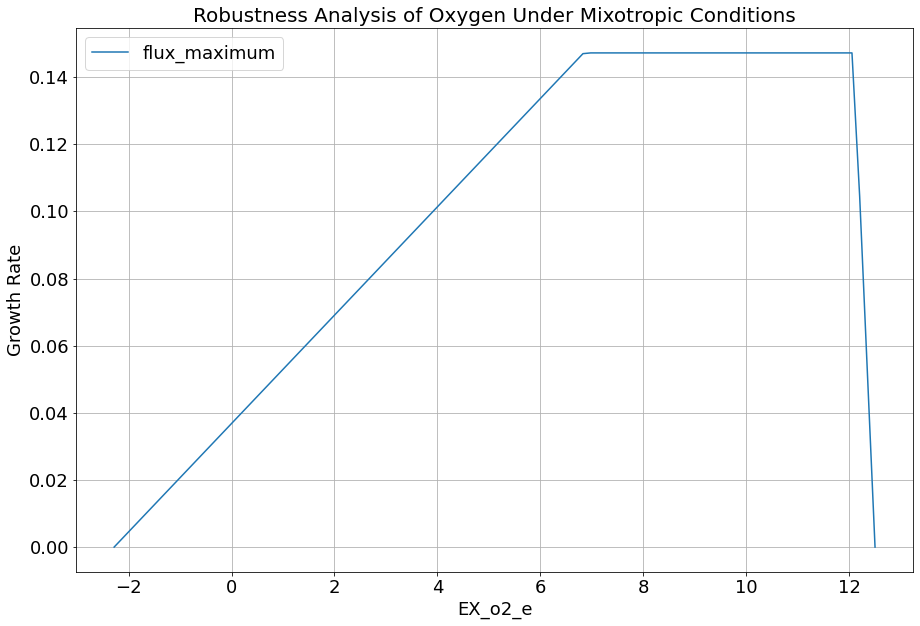

In [12]:
ax = RA_o2.plot(kind='line', x='EX_o2_e', y='flux_maximum',figsize=(15,10),fontsize = 18, grid = True)
ax.set_xlabel('EX_o2_e',size = 18)
ax.set_ylabel('Growth Rate',size = 18)
ax.set_title('Robustness Analysis of Oxygen Under Mixotropic Conditions',size = 20)
plt.legend(fontsize=18) 
plt.show();

Note that in mixotrophic operation oxygen can either be brought into the cell for anaerobic operation with no light or secreted during photosynthesis driven aerobic operation.

Let's look at the robustness analysis for carbonate.

In [13]:
model = model_mix.copy()
model.reactions.EX_hco3_e.bounds = [-12,0] # Providing more range for the robustness analysis
RA_hco3 = production_envelope(
    model, ["EX_hco3_e"], objective="BIOMASS_Ec_SynMixo", carbon_sources="EX_hco3_e", points=100)
RA_hco3.round(5)

carbon_source  flux_minimum  carbon_yield_minimum  mass_yield_minimum  flux_maximum  carbon_yield_maximum  mass_yield_maximum  EX_hco3_e
0      EX_hco3_e           0.0                   0.0                 NaN       0.21784               7.70560                 NaN  -12.00000
1      EX_hco3_e           0.0                   0.0                 NaN       0.21784               7.78423                 NaN  -11.87879
2      EX_hco3_e           0.0                   0.0                 NaN       0.21784               7.86448                 NaN  -11.75758
3      EX_hco3_e           0.0                   0.0                 NaN       0.21784               7.94640                 NaN  -11.63636
4      EX_hco3_e           0.0                   0.0                 NaN       0.21784               8.03005                 NaN  -11.51515
5      EX_hco3_e           0.0                   0.0                 NaN       0.21784               8.11548                 NaN  -11.39394
6      EX_hco3_e           0.0                   0.0                 NaN       0.21784               8.20274                 NaN  -11.27273
7      EX_hco3_e           0.0                   0.0                 NaN       0.21784               8.29190                 NaN  -11.15152
8      EX_hco3_e           0.0                   0.0                 NaN       0.21784               8.38302                 NaN  -11.03030
9      EX_hco3_e           0.0                   0.0                 NaN       0.21784               8.47617                 NaN  -10.90909
10     EX_hco3_e           0.0                   0.0                 NaN       0.21784               8.57140                 NaN  -10.78788
11     EX_hco3_e           0.0                   0.0                 NaN       0.21784               8.66881                 NaN  -10.66667
12     EX_hco3_e           0.0                   0.0                 NaN       0.21784               8.76845                 NaN  -10.54545
13     EX_hco3_e           0.0                   0.0                 NaN       0.21784               8.87041                 NaN  -10.42424
14     EX_hco3_e           0.0                   0.0                 NaN       0.21784               8.97476                 NaN  -10.30303
15     EX_hco3_e           0.0                   0.0                 NaN       0.21784               9.08161                 NaN  -10.18182
16     EX_hco3_e           0.0                   0.0                 NaN       0.21784               9.19102                 NaN  -10.06061
17     EX_hco3_e           0.0                   0.0                 NaN       0.21784               9.30311                 NaN   -9.93939
18     EX_hco3_e           0.0                   0.0                 NaN       0.21784               9.41796                 NaN   -9.81818
19     EX_hco3_e           0.0                   0.0                 NaN       0.21784               9.53569                 NaN   -9.69697
20     EX_hco3_e           0.0                   0.0                 NaN       0.21784               9.65639                 NaN   -9.57576
21     EX_hco3_e           0.0                   0.0                 NaN       0.21784               9.78019                 NaN   -9.45455
22     EX_hco3_e           0.0                   0.0                 NaN       0.21784               9.90721                 NaN   -9.33333
23     EX_hco3_e           0.0                   0.0                 NaN       0.21784              10.03756                 NaN   -9.21212
24     EX_hco3_e           0.0                   0.0                 NaN       0.21784              10.17140                 NaN   -9.09091
25     EX_hco3_e           0.0                   0.0                 NaN       0.21784              10.30885                 NaN   -8.96970
26     EX_hco3_e           0.0                   0.0                 NaN       0.21784              10.45007                 NaN   -8.84848
27     EX_hco3_e           0.0                   0.0                 NaN       0.21

In [14]:
ax = RA_hco3.plot(kind='line', x='EX_hco3_e', y='flux_maximum',figsize=(15,10),fontsize = 18, grid = True)
ax.set_xlabel('EX_hco3_e',size = 18)
ax.set_ylabel('Growth Rate',size = 18)
ax.set_title('Robustness Analysis of Bicarbonate Under Mixotropic Conditions',size = 20)
plt.legend(fontsize=18) 
plt.show();

Note that there is an upper limit to the growth based on carbonate as a carbon source.

Now let's look at the growth capability as a function of glucose in this mixotrophic setting.

In [15]:
model = model_mix.copy()
model.reactions.EX_glc__D_e.bounds = [-10,0] # Providing more range for the robustness analysis
RA_hco3 = production_envelope(
    model, ["EX_glc__D_e"], objective="BIOMASS_Ec_SynMixo", carbon_sources="EX_glc__D_e", points=100)
RA_hco3.round(5)

carbon_source  flux_minimum  carbon_yield_minimum  mass_yield_minimum  flux_maximum  carbon_yield_maximum  mass_yield_maximum  EX_glc__D_e
0    EX_glc__D_e           0.0                   0.0                 NaN       1.00094               7.08129                 NaN    -10.00000
1    EX_glc__D_e           0.0                   0.0                 NaN       0.99337               7.09947                 NaN     -9.89899
2    EX_glc__D_e           0.0                   0.0                 NaN       0.98581               7.11803                 NaN     -9.79798
3    EX_glc__D_e           0.0                   0.0                 NaN       0.97824               7.13696                 NaN     -9.69697
4    EX_glc__D_e           0.0                   0.0                 NaN       0.97067               7.15630                 NaN     -9.59596
5    EX_glc__D_e           0.0                   0.0                 NaN       0.96311               7.17605                 NaN     -9.49495
6    EX_glc__D_e           0.0                   0.0                 NaN       0.95554               7.19623                 NaN     -9.39394
7    EX_glc__D_e           0.0                   0.0                 NaN       0.94797               7.21684                 NaN     -9.29293
8    EX_glc__D_e           0.0                   0.0                 NaN       0.94041               7.23791                 NaN     -9.19192
9    EX_glc__D_e           0.0                   0.0                 NaN       0.93284               7.25944                 NaN     -9.09091
10   EX_glc__D_e           0.0                   0.0                 NaN       0.92527               7.28146                 NaN     -8.98990
11   EX_glc__D_e           0.0                   0.0                 NaN       0.91770               7.30398                 NaN     -8.88889
12   EX_glc__D_e           0.0                   0.0                 NaN       0.91014               7.32701                 NaN     -8.78788
13   EX_glc__D_e           0.0                   0.0                 NaN       0.90257               7.35058                 NaN     -8.68687
14   EX_glc__D_e           0.0                   0.0                 NaN       0.89500               7.37471                 NaN     -8.58586
15   EX_glc__D_e           0.0                   0.0                 NaN       0.88744               7.39941                 NaN     -8.48485
16   EX_glc__D_e           0.0                   0.0                 NaN       0.87987               7.42471                 NaN     -8.38384
17   EX_glc__D_e           0.0                   0.0                 NaN       0.87230               7.45062                 NaN     -8.28283
18   EX_glc__D_e           0.0                   0.0                 NaN       0.86474               7.47717                 NaN     -8.18182
19   EX_glc__D_e           0.0                   0.0                 NaN       0.85717               7.50439                 NaN     -8.08081
20   EX_glc__D_e           0.0                   0.0                 NaN       0.84960               7.53230                 NaN     -7.97980
21   EX_glc__D_e           0.0                   0.0                 NaN       0.84203               7.56092                 NaN     -7.87879
22   EX_glc__D_e           0.0                   0.0                 NaN       0.83447               7.59028                 NaN     -7.77778
23   EX_glc__D_e           0.0                   0.0                 NaN       0.82690               7.62042                 NaN     -7.67677
24   EX_glc__D_e           0.0                   0.0                 NaN       0.81933               7.65136                 NaN     -7.57576
25   EX_glc__D_e           0.0                   0.0                 NaN       0.81177               7.68314                 NaN     -7.47475
26   EX_glc__D_e           0.0                   0.0                 NaN       0.80420               7.71579                 NaN     -7.37374
27   EX_glc__D_e           

Plotting the results

In [16]:
ax = RA_hco3.plot(kind='line', x='EX_glc__D_e', y='flux_maximum',figsize=(15,10),fontsize = 18, grid = True)
ax.set_xlabel('EX_glc__D_e',size = 18)
ax.set_ylabel('Growth Rate',size = 18)
ax.set_title('Robustness Analysis of Glucose Under Mixotropic Conditions',size = 20)
plt.legend(fontsize=18) 
plt.show();

Note that there are a few kinks in the plot indicating that the growth does not increase linearly with glucose uptake but passes throuogh a couple of different phenotypes as the glucose uptake increases.

### Photosynthsis and Oxidative Phosphorylation

The photosynthesis and oxidative phosphoylation pathways illustrated in the Nogales paper [1] is shown below.

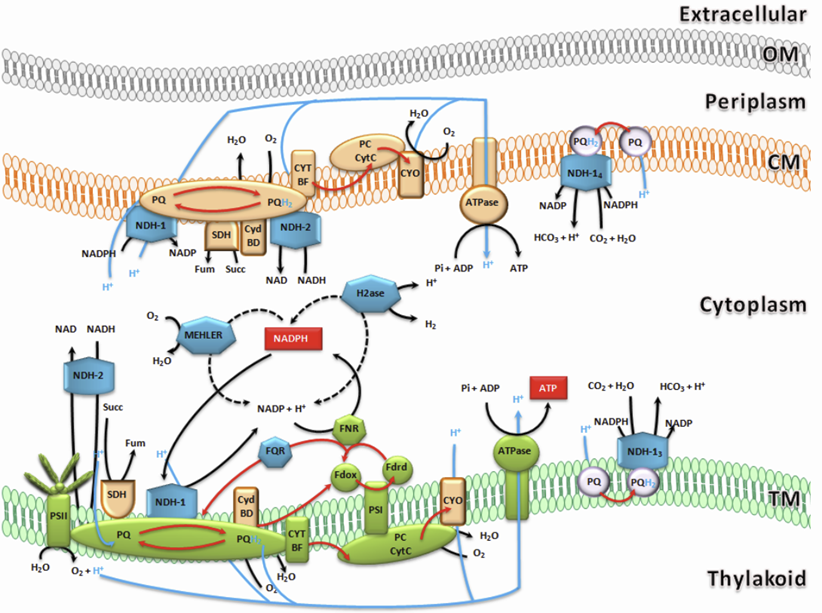

In this figure, the oxidative phosphylation pathways are shown at the top of the figure associated with the cell membrane (CM) while the photosynthesis pathways are shown at the bottom of the figure associated with the thylakoid membrane.

An Escher map showing the iJN678 model of both the photosynthesis and oxidative phosphoylation pathways is shown below (iJN678.Combined.png)

## Exploring the iJN678 Mixotrophic Fluxes as the Glucose Flux Varies

Create flux data for the reactions in the oxidative phosphorylation pathways as the glucose flux changes from 0 to 0.38 while holding the photon flux to it's optimized value of -61.

In [17]:
%matplotlib inline
model = model_mix.copy()

m_reactions = ['PSII','CYTBDu','SUCDu_syn','CBFCu','PSI','CYO1b2_syn','ATPSu','PSI_2',
               'CBFC2','CYO1b_syn','NDH1_1u','NDH1_2u','NDH1_3u','FNOR','FQR',
               'H2ASE_syn','MEHLER','HCO3E','RBPC','RBCh', 'NDH1_2p','CBFCpp','CYO1b2pp_syn',
               'ATPS4rpp_1','CYO1bpp_syn','CYTBDpp_1','NADH5','NDH1_1p','CBFC2pp',
               'NDH2_syn','SUCDi','SUCDu_syn','EX_photon_e','EX_glc__D_e',
               'BIOMASS_Ec_SynMixo','EX_no3_e','GLCS1']

model.reactions.EX_photon_e.bounds = [-61,-61] #Optimized value = 61.48
tsolution = []
x=0
for i in range(100):
    model.reactions.EX_glc__D_e.bounds = [-x,-x] # Adjust the photon flux to go from 0 to -100
    #tsolution.append(model.optimize()) # For each photon flux value do FBA
    tsolution.append(loopless_solution(model)) # Loopless FBA
    x +=0.38/100

df = pd.DataFrame()
for reaction in m_reactions:
    f=[]
    for i in range(100):
        f.append(tsolution[i].fluxes[reaction]) # Create a list of fluxes for a given reaction
    df_temp = pd.DataFrame(f) # Convert the list to a Pandas Dataframe
    df[reaction] = df_temp # Add the new dataframe to the dataframe that will hold all the fluxes
df = df.round(5)
df

PSII   CYTBDu  SUCDu_syn     CBFCu       PSI  CYO1b2_syn    ATPSu  PSI_2  CBFC2  CYO1b_syn  ...  NADH5  NDH1_1p  CBFC2pp  NDH2_syn  SUCDi  EX_photon_e  EX_glc__D_e  BIOMASS_Ec_SynMixo  EX_no3_e  GLCS1
0   18.48238  4.53985        0.0  13.94253  12.01762     1.92491  6.89891    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -61.0       0.0000             0.09110  -0.82117    0.0
1   18.45393  4.45678        0.0  13.99714  12.04607     1.95107  6.91418    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -61.0      -0.0038             0.09166  -0.82623    0.0
2   18.42547  4.37371        0.0  14.05177  12.07453     1.97724  6.92946    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -61.0      -0.0076             0.09222  -0.83129    0.0
3   18.39702  4.29063        0.0  14.10639  12.10298     2.00340  6.94474    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -61.0      -0.0114             0.09278  -0.83635    0.0
4   18.36856  4.20756        0.0  14.16101  12.13144     2.02957  6.96002    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -61.0      -0.0152             0.09334  -0.84141    0.0
5   18.34011  4.12448        0.0  14.21563  12.15989     2.05573  6.97530    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -61.0      -0.0190             0.09391  -0.84647    0.0
6   18.31165  4.04141        0.0  14.27025  12.18835     2.08190  6.99058    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -61.0      -0.0228             0.09447  -0.85153    0.0
7   18.28320  3.95833        0.0  14.32487  12.21680     2.10807  7.00586    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -61.0      -0.0266             0.09503  -0.85659    0.0
8   18.25474  3.87526        0.0  14.37949  12.24526     2.13423  7.02114    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -61.0      -0.0304             0.09559  -0.86165    0.0
9   18.22629  3.79218        0.0  14.43411  12.27371     2.16040  7.03641    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -61.0      -0.0342             0.09615  -0.86671    0.0
10  18.19784  3.70911        0.0  14.48873  12.30216     2.18656  7.05169    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -61.0      -0.0380             0.09671  -0.87177    0.0
11  18.16938  3.62603        0.0  14.54335  12.33062     2.21273  7.06697    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -61.0      -0.0418             0.09727  -0.87683    0.0
12  18.14093  3.54296        0.0  14.59797  12.35907     2.23889  7.08225    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -61.0      -0.0456             0.09783  -0.88189    0.0
13  18.11247  3.45988        0.0  14.65259  12.38753     2.26506  7.09753    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -61.0      -0.0494             0.09840  -0.88695    0.0
14  18.08402  3.37681        0.0  14.70721  12.41598     2.29123  7.11281    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -61.0      -0.0532             0.09896  -0.89201    0.0
15  18.05556  3.29373        0.0  14.76183  12.44444     2.31739  7.12809    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -61.0      -0.0570             0.09952  -0.89707    0.0
16  18.02711  3.21066        0.0  14.81645  12.47289     2.34356  7.14337    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -61.0      -0.0608             0.10008  -0.90213    0.0
17  17.99865  3.12758        0.0  14.87107  12.50135     2.36972  7.15865    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -61.0      -0.0646             0.10064  -0.90719    0.0
18  17.97020  3.04451        0.0  14.

Let's plot the results

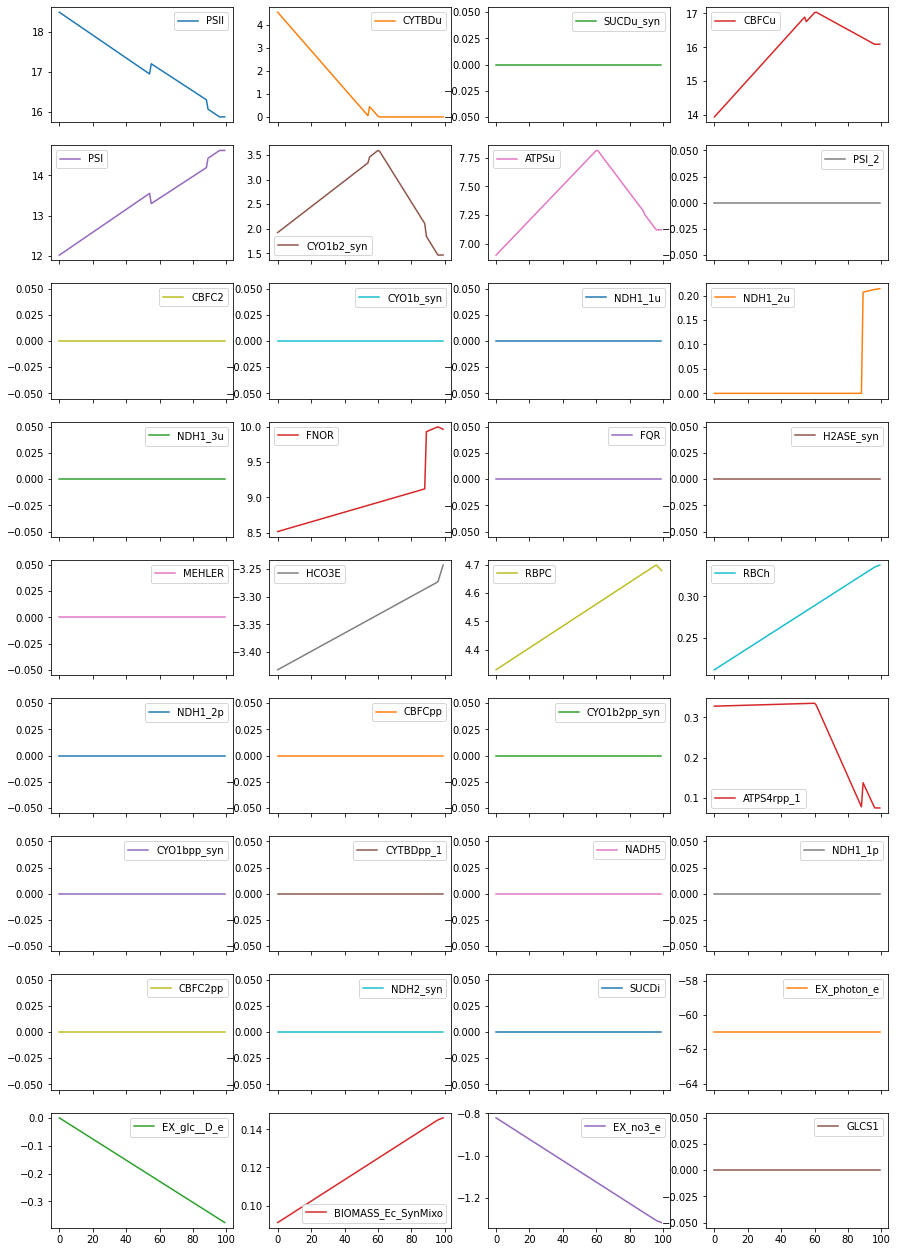

In [18]:
df.plot(subplots=True, layout=(10,4),figsize=(15,25));

As the additional glucose is added to the cell's energy machinery it gets to a point where the ATP production
starts to drop at both the cell and thylakoid membranes. There is a lot more going on that will require more analysis.

## Exploring the iJN678 Mixotrophic Fluxes as the Photon Flux Varies

Now let's look at the reaction changes when the glucose is held constant at 0.38 and the photon flux changes from 0 to 100.

In [19]:
model = model_mix.copy()
m_reactions = ['PSII','CYTBDu','SUCDu_syn','CBFCu','PSI','CYO1b2_syn','ATPSu','PSI_2',
               'CBFC2','CYO1b_syn','NDH1_1u','NDH1_2u','NDH1_3u','FNOR','FQR',
               'H2ASE_syn','MEHLER','HCO3E','RBPC','RBCh', 'NDH1_2p','CBFCpp','CYO1b2pp_syn',
               'ATPS4rpp_1','CYO1bpp_syn','CYTBDpp_1','NADH5','NDH1_1p','CBFC2pp',
               'NDH2_syn','SUCDi','SUCDu_syn','EX_photon_e','EX_glc__D_e',
               'BIOMASS_Ec_SynMixo','EX_no3_e','GLCS1']  

model.reactions.EX_glc__D_e.bounds = [-0.38,-0.38]
tsolution = []
x=0
for i in range(100):
    model.reactions.EX_photon_e.bounds = [-x,-x] # Adjust the photon flux to go from 0 to -100
    tsolution.append(model.optimize()) # For each photon flux value do FBA
    x +=1/100

df2 = pd.DataFrame()
for reaction in m_reactions:
    f=[]
    for i in range(100):
        f.append(tsolution[i].fluxes[reaction]) # Create a list of fluxes for a given reaction
    df_temp = pd.DataFrame(f) # Convert the list to a Pandas Dataframe
    df2[reaction] = df_temp # Add the new dataframe to the dataframe that will hold all the fluxes
df2 = df2.round(4)
df2

PSII  CYTBDu  SUCDu_syn   CBFCu  PSI  CYO1b2_syn   ATPSu  PSI_2  CBFC2  CYO1b_syn  ...  NADH5  NDH1_1p  CBFC2pp  NDH2_syn  SUCDi  EX_photon_e  EX_glc__D_e  BIOMASS_Ec_SynMixo  EX_no3_e  GLCS1
0   0.000     0.0     0.1960  0.8805  0.0      0.8805  0.5240    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0         0.00        -0.38              0.0283   -0.2551    0.0
1   0.005     0.0     0.1948  0.8821  0.0      0.8821  0.5250    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -0.01        -0.38              0.0283   -0.2554    0.0
2   0.010     0.0     0.1936  0.8837  0.0      0.8837  0.5259    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -0.02        -0.38              0.0284   -0.2556    0.0
3   0.015     0.0     0.1924  0.8853  0.0      0.8853  0.5269    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -0.03        -0.38              0.0284   -0.2558    0.0
4   0.020     0.0     0.1911  0.8870  0.0      0.8870  0.5278    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -0.04        -0.38              0.0284   -0.2561    0.0
5   0.025     0.0     0.1899  0.8886  0.0      0.8886  0.5288    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -0.05        -0.38              0.0284   -0.2563    0.0
6   0.030     0.0     0.1887  0.8902  0.0      0.8902  0.5297    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -0.06        -0.38              0.0285   -0.2565    0.0
7   0.035     0.0     0.1874  0.8919  0.0      0.8919  0.5307    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -0.07        -0.38              0.0285   -0.2568    0.0
8   0.040     0.0     0.1862  0.8935  0.0      0.8935  0.5316    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -0.08        -0.38              0.0285   -0.2570    0.0
9   0.045     0.0     0.1850  0.8951  0.0      0.8951  0.5326    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -0.09        -0.38              0.0285   -0.2572    0.0
10  0.050     0.0     0.1838  0.8968  0.0      0.8968  0.5335    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -0.10        -0.38              0.0286   -0.2575    0.0
11  0.055     0.0     0.1825  0.8984  0.0      0.8984  0.5345    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -0.11        -0.38              0.0286   -0.2577    0.0
12  0.060     0.0     0.1813  0.9000  0.0      0.9000  0.5355    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -0.12        -0.38              0.0286   -0.2580    0.0
13  0.065     0.0     0.1801  0.9017  0.0      0.9017  0.5364    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -0.13        -0.38              0.0286   -0.2582    0.0
14  0.070     0.0     0.1789  0.9033  0.0      0.9033  0.5374    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -0.14        -0.38              0.0287   -0.2584    0.0
15  0.075     0.0     0.1776  0.9049  0.0      0.9049  0.5383    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -0.15        -0.38              0.0287   -0.2587    0.0
16  0.080     0.0     0.1764  0.9066  0.0      0.9066  0.5393    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -0.16        -0.38              0.0287   -0.2589    0.0
17  0.085     0.0     0.1752  0.9082  0.0      0.9082  0.5402    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -0.17        -0.38              0.0287   -0.2591    0.0
18  0.090     0.0     0.1740  0.9098  0.0      0.9098  0.5412    0.0    0.0        0.0  ...    0.0      0.0      0.0       0.0    0.0        -0.18        -0.38              0.0288   -0.2594    0.0
19  0.095     0.0     0.1727  0.9115  0.0      0.9115  0.5421    

Plotting the results

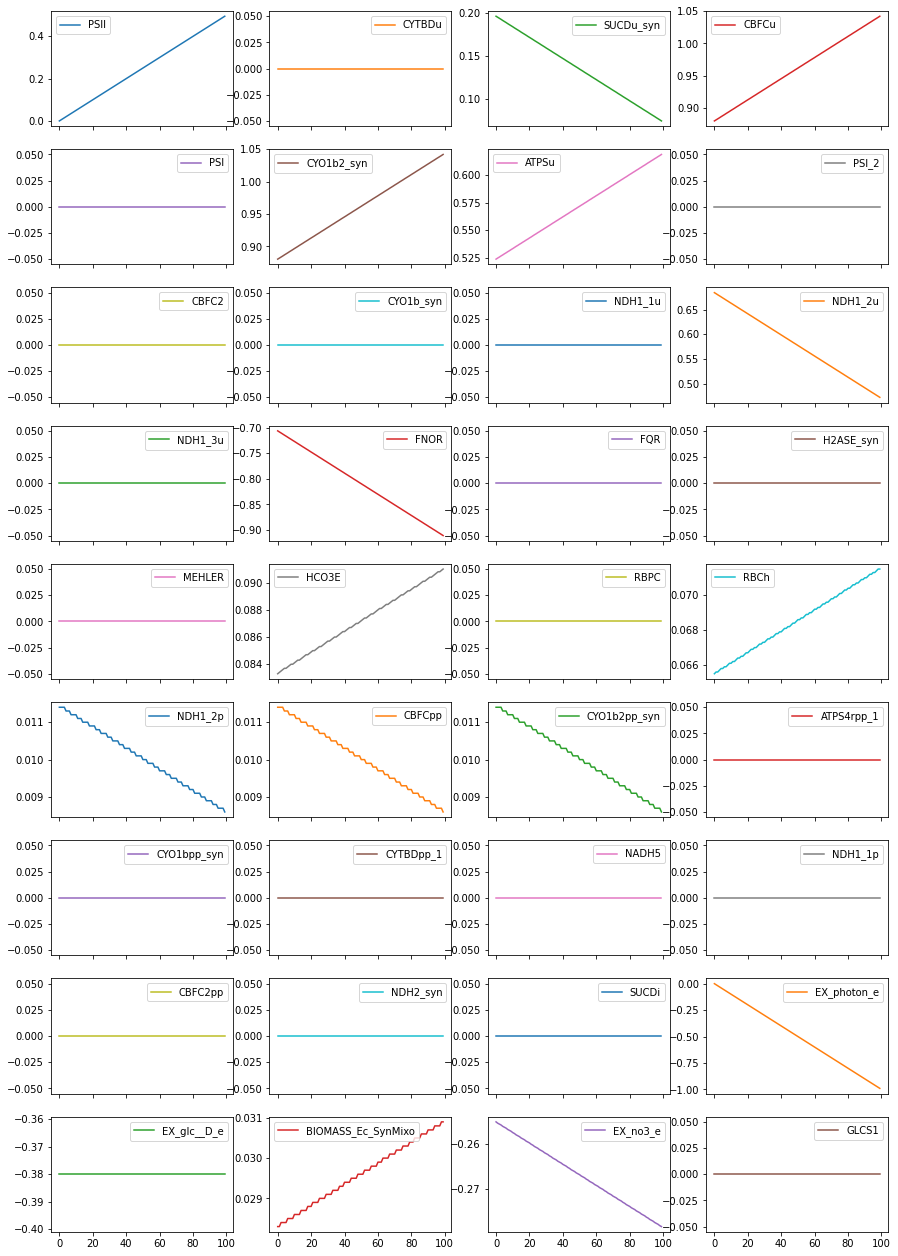

In [20]:
df2.plot(subplots=True, layout=(10,4),figsize=(15,25));

From these results, we can see that the standard flow through both the electron transport chains includes the following thylakoid membrane reactions, PSII, CBFCu, PSI, FNOR (NADPH production) and ATPS4u (ATP production), in addition to the cellular membrane reactions of NDH1_2p, CBFCpp, CYO1b2pp_syn and ATPS4rpp_1(ATP production). Thus, both the normal oxidative phosphorylation and photsynthesis pathways seem to be operating in their standard configuations and the additional light input adds energy and reducing power to the cells operation.

## Optimized Flux Values for Mixotrophic Operation

In [21]:
model = model_mix.copy()
solution = model.optimize()
solution_frame = solution.to_frame()
solution_frame = solution_frame.sort_index()
solution_frame.round(5)

fluxes  reduced_costs
34DHOXPEGOX            0.00000        0.00000
34HPPOR                0.00008        0.00000
3HAD100                0.06119        0.00000
3HAD120                0.05796        0.00000
3HAD121                0.00323        0.00000
3HAD140                0.04311        0.00000
3HAD141                0.00323        0.00000
3HAD160                0.04311        0.00000
3HAD161                0.00323        0.00000
3HAD180                0.01867        0.00000
3HAD181                0.00140        0.00000
3HAD40                 0.06119        0.00000
3HAD60                 0.06119        0.00000
3HAD80                 0.06119        0.00000
3OAR100                0.06119        0.00000
3OAR120                0.05796        0.00000
3OAR121                0.00323        0.00000
3OAR140                0.05796        0.00000
3OAR141                0.00323        0.00000
3OAR160                0.04311        0.00000
3OAR161                0.00323        0.00000
3OAR180                0.01867       -0.00000
3OAR181                0.00140        0.00000
3OAR40                 0.06119        0.00000
3OAR60                 0.06119        0.00000
3OAR80                 0.06119        0.00000
3OAS100                0.06119        0.00000
3OAS120                0.05796        0.00000
3OAS121                0.00323        0.00000
3OAS140                0.05796        0.00000
3OAS141                0.00323        0.00000
3OAS160                0.04311        0.00000
3OAS161                0.00323        0.00000
3OAS180                0.01867        0.00000
3OAS181                0.00140        0.00000
3OAS60                 0.06119        0.00000
3OAS80                 0.06119        0.00000
AACOAR_syn             0.00000        0.00000
ABTA                   0.00001       -0.00000
ABUTD                  0.00000       -0.00000
ACACT1r                0.00000       -0.19697
ACBIPGT                0.00003        0.00000
ACCOAC                 0.43356        0.00000
ACGK                   0.04004        0.00000
ACGS                   0.00000       -0.34470
ACHBS                  0.04253        0.00000
ACKr                   0.02865        0.00000
ACLS                   0.12306       -0.00000
ACOATA                 0.00000       -0.00000
ACONT                  0.18368        0.00000
ACOTA                 -0.04004        0.00000
ACP1_FMN               0.00000       -0.00000
ACS                    0.00000        0.00000
ACt2rpp               -0.00000       -0.00000
ACtex                 -0.00000       -0.00000
ADCL                   0.00013        0.00000
ADCPS1                 0.00000       -2.70833
ADCPS2                 0.00003       -0.00000
ADCS                   0.00013        0.00000
ADCYRS                 0.00003        0.00000
ADK1                   0.30849        0.00000
ADMDC                  0.00099       -0.00000
ADNCYC                 0.00000        0.00000
ADOCBLS                0.00003        0.00000
ADPRDP                 0.00000        0.00000
ADPT                   0.00470        0.00000
ADPT2                  0.00000       -0.00000
ADSK                   0.02738        0.00000
ADSL1r                 0.03706        0.00000
ADSL2r                 0.04771       -0.00000
ADSS                   0.03706       -0.00000
AGMT                   0.00589        0.00000
AGPAT160               0.01222        0.00000
AGPAT161               0.00091        0.00000
AGPAT180               0.00018       -0.00000
AGPAT181               0.00070        0.00000
AGPAT181_9             0.00070        0.00000
AGPAT182_9_12          0.00417       -0.00000
AGPAT183_6_9_12        0.00385        0.00000
AGPAT183_9_12_15       0.00028        0.00000
AGPAT184_6_9_12_15     0.00016        0.00000
AGPR                  -0.04004       -0.00000
AGTi                   0.34097       -0.00000
AHCi                   0.00371        0.00000
AHMMPS                 0.00000        0.00000
AHSERL2                0.01432       -0.00000
AICART                

The oxidative phosphorylation subsystem fluxes are

In [22]:
solution.fluxes[m_reactions]

PSII                  1.600318e+01
CYTBDu                0.000000e+00
SUCDu_syn             0.000000e+00
CBFCu                 1.600318e+01
PSI                   1.473804e+01
CYO1b2_syn            1.265138e+00
ATPSu                 7.039240e+00
PSI_2                 0.000000e+00
CBFC2                 0.000000e+00
CYO1b_syn             0.000000e+00
NDH1_1u               0.000000e+00
NDH1_2u               0.000000e+00
NDH1_3u              -3.300462e-15
FNOR                  1.008503e+01
FQR                   0.000000e+00
H2ASE_syn             0.000000e+00
MEHLER                0.000000e+00
HCO3E                -3.266437e+00
RBPC                  4.716297e+00
RBCh                  3.408374e-01
NDH1_2p               2.159377e-01
CBFCpp                2.159377e-01
CYO1b2pp_syn          2.159377e-01
ATPS4rpp_1            2.145883e-01
CYO1bpp_syn           0.000000e+00
CYTBDpp_1             0.000000e+00
NADH5                 0.000000e+00
NDH1_1p               0.000000e+00
CBFC2pp             

Let's now look at the reactions associated with oxidative phosphorylation on an Escher map in the optimal phenotype calculated by flux balance analysis.

In [23]:
builder2 = Builder(
    model_json='./iJN678.json', 
)
builder2.map_json = './iJN678.Combined.json'
builder2

Builder()

In [24]:
builder2.reaction_data = solution.fluxes

## Mixotrophic Cellular Operation

Now let's look at the flow of flux through the metabolic core of iJN678.

The summary of the flow into and out of the cell

In [25]:
model.summary()

Note that they optimized operating condition is aerobic!

Nogales et al [1] provided a map of the core operation of the cell in mixotrophic operation.



Let's now explore an Escher map of that core with optimal flux flowing

In [26]:
builder = Builder(
    model_json='./iJN678.json', 
)
builder.map_json = './iJN678.Core_metabolism.json'
builder

Builder()

In [27]:
builder.reaction_data = solution.fluxes

Under mixotrophic conditions, glucose was metabolized via the non-oxidative pentose phosphate pathway to produce ribulose-1,5-diphosphate. Furthermore, 3PG was produced by RuBisCO. However, the PGM/PGK ratio was reversed under mixotrophic conditions due to the flux of exogenous glucose to fructose-6-phosphate. Pyruvate was mainly produced by PYK. Another interesting characteristic of the mixotrophic metabolism was that a small but significant respiratory rate is predicted for maximum growth under this condition.[1]

Where is the NADPH and ATP produced?

In [28]:
model.metabolites.nadph_c.summary()

In [29]:
model.metabolites.atp_c.summary()

The majority of the ATP and NADPH is produced by the photosynthetic machinery, which is what is expected since the model is set for the optimal light input.

## Flux Variability Analysis of the Mixotrophic iJN678 model

Let's now look at the flux variability analysis for the the mixotrophic model.

In [30]:
from cobra.flux_analysis import flux_variability_analysis
model2=model_orig.copy()
model2.objective = 'BIOMASS_Ec_SynMixo'

fva = flux_variability_analysis(model2, reaction_list = m_reactions, loopless=True, 
                                fraction_of_optimum=0.99)
fva.sort_index().round(4)

minimum  maximum
ATPS4rpp_1           1.1455   1.3131
ATPSu                0.0000   0.0000
BIOMASS_Ec_SynMixo   0.0627   0.0633
CBFC2                0.0000   0.0000
CBFC2pp              0.0000   2.0771
CBFCpp               0.0000   2.0771
CBFCu                0.0000   0.0000
CYO1b2_syn           0.0000   0.0000
CYO1b2pp_syn         0.0000   2.0767
CYO1b_syn            0.0000   0.0000
CYO1bpp_syn          0.0000   2.0768
CYTBDpp_1            0.0000   0.0000
CYTBDu               0.0000   0.0000
EX_glc__D_e         -0.8500  -0.8415
EX_no3_e            -0.5771  -0.5650
EX_photon_e          0.0000   0.0000
FNOR                -2.2784  -1.5531
FQR                  0.0000   0.0000
GLCS1                0.0000   0.0000
H2ASE_syn            0.0000   0.1011
HCO3E                0.0000   0.1863
MEHLER               0.0000   0.0000
NADH5                0.0000   0.0000
NDH1_1p              0.0000   1.4293
NDH1_1u              0.0000   0.0000
NDH1_2p              0.6474   2.0767
NDH1_2u              0.0000   0.0000
NDH1_3u              0.0000   0.0000
NDH2_syn             0.0000   0.0000
PSI                  0.0000   0.0000
PSII                 0.0000   0.0000
PSI_2                0.0000   0.0000
RBCh                 0.1451   0.1768
RBPC                 0.0000   0.0000
SUCDi                0.0000   0.0000
SUCDu_syn            0.0000   0.0000
SUCDu_syn            0.0000   0.0000

As a reminder, the reactions with a zero flux span will never be active in the current mixotrophic configuration. 

## References

1. Nogales, J., S. Gudmundsson, et al. (2012). "Detailing the optimality of photosynthesis in cyanobacteria through systems biology analysis." Proceedings of the National Academy of Sciences of the United States of America 109(7): 2678-2683.